In [1]:
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_validation_dataset = datasets.FashionMNIST('data', train = True, download=True, transform=transform)
train_dataset, valid_dataset = random_split(train_validation_dataset, [0.8, 0.2])
test_dataset = datasets.FashionMNIST('data', train = False, download=True,transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 17173781.22it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 275412.49it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5088857.85it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21549178.63it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
def visualize(image, label):
  plt.figure()
  plt.imshow(image, cmap='gray')
  plt.title(str(label))
  plt.xticks([])
  plt.yticks([])


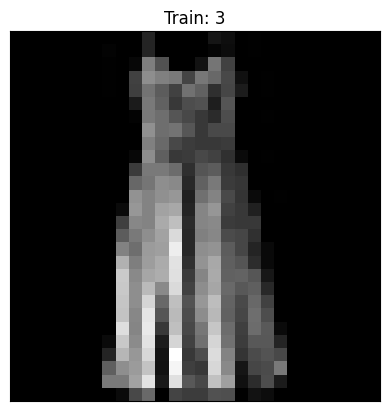

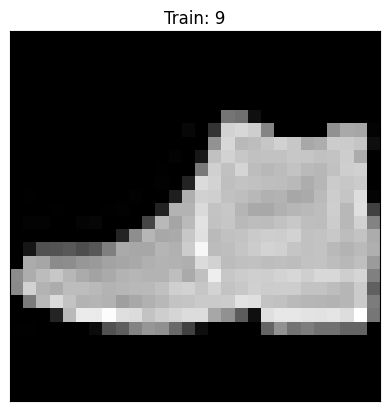

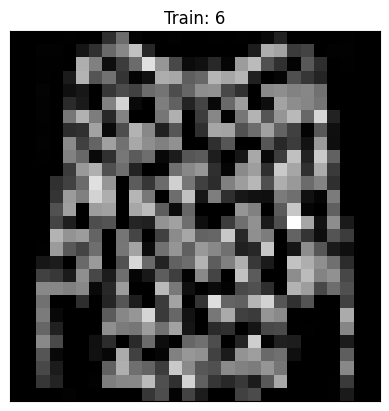

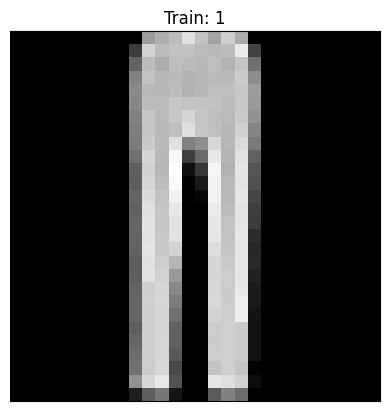

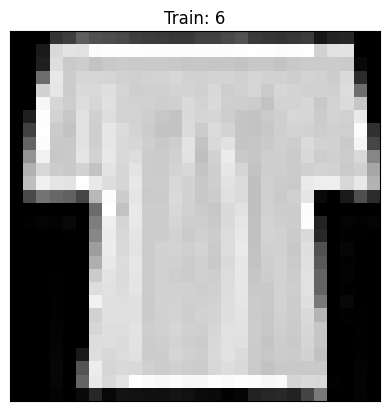

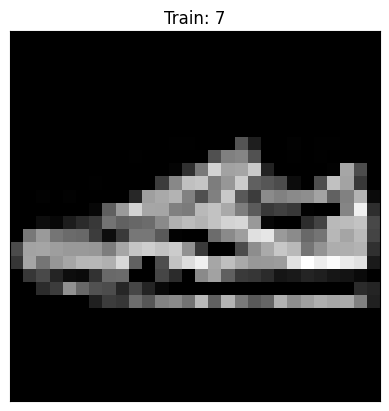

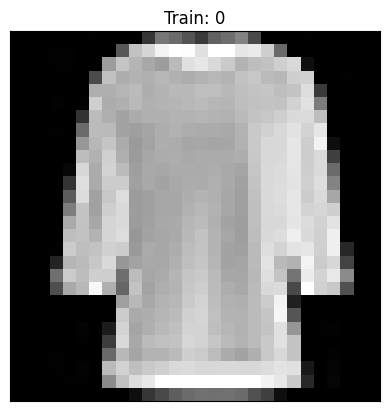

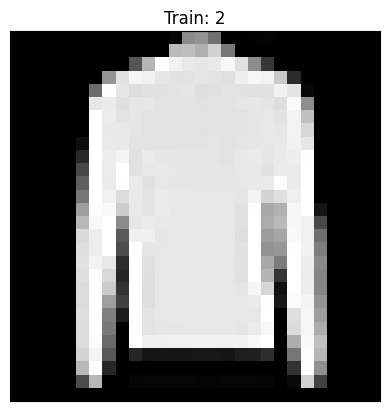

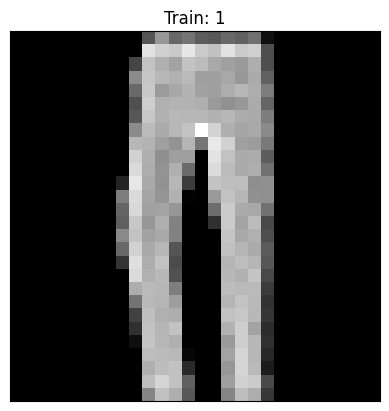

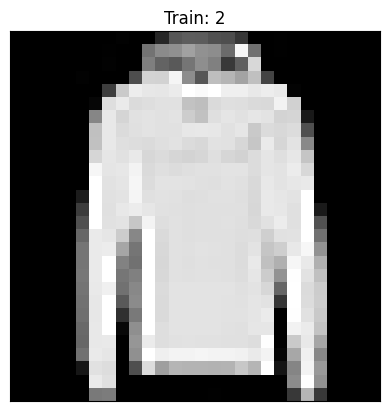

In [4]:
train_examples = [train_dataset[i] for i in range(10)]
for image, label in train_examples:
  visualize(image.numpy()[0], f'Train: {label}')

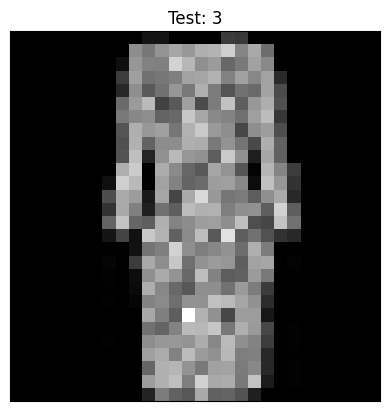

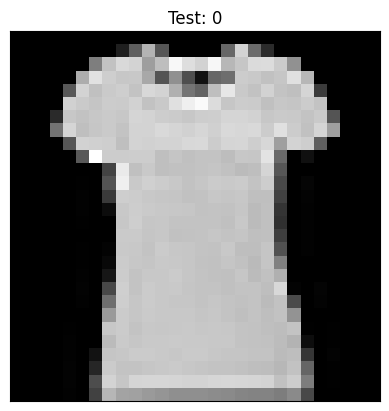

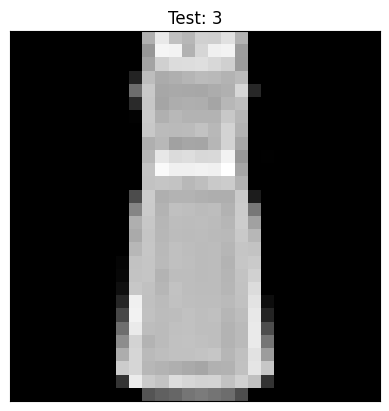

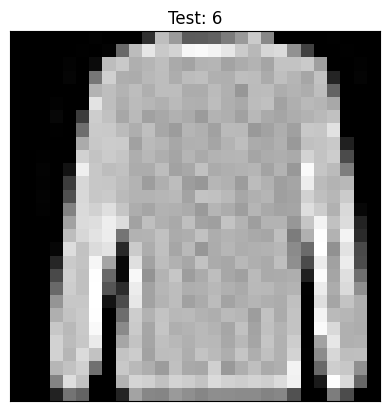

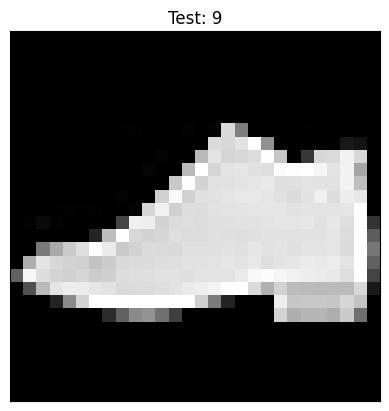

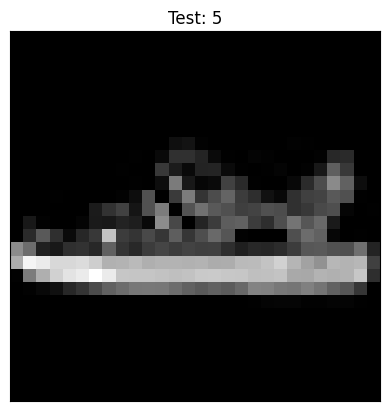

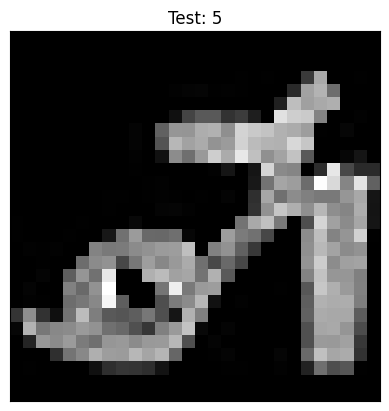

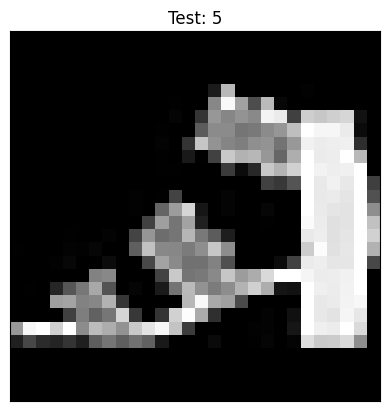

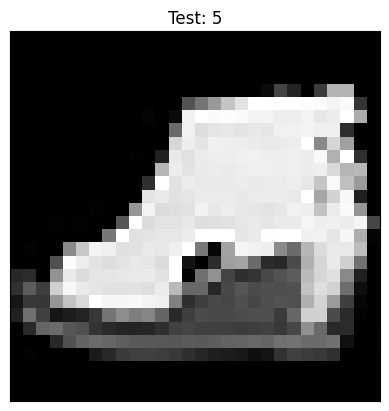

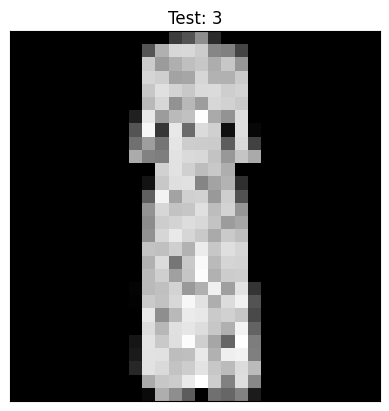

In [5]:
train_examples = [valid_dataset[i] for i in range(10)]
for image, label in train_examples:
  visualize(image.numpy()[0], f'Test: {label}')


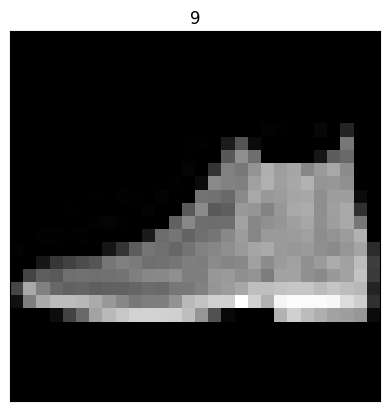

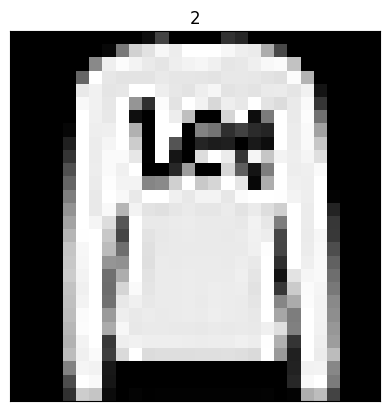

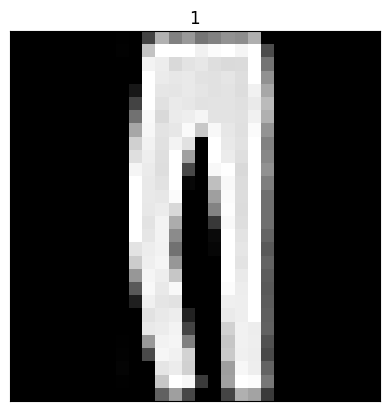

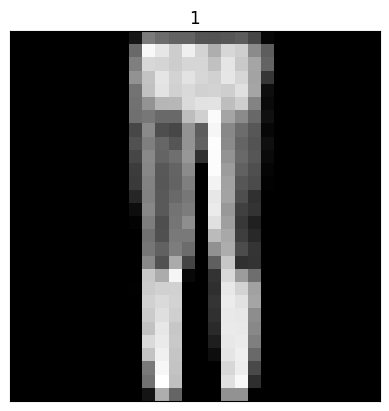

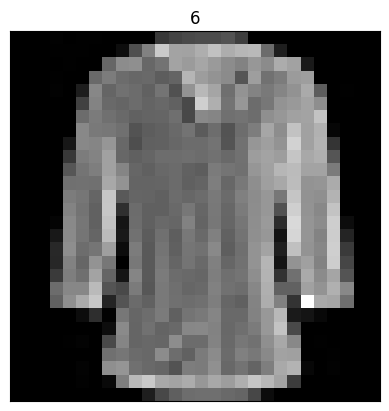

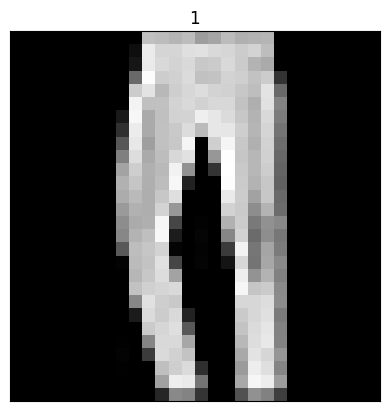

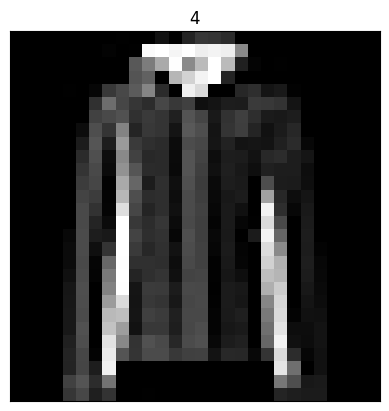

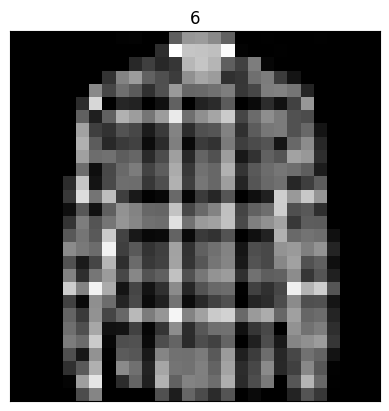

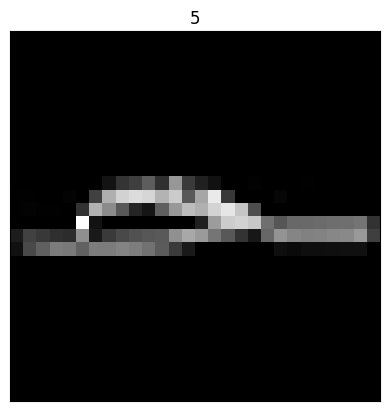

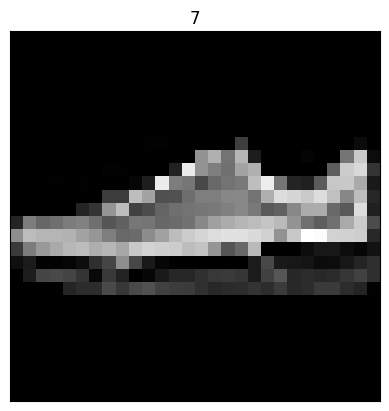

In [6]:
test_examples = [test_dataset[i] for i in range(10)]
for image, label in test_examples:
  visualize(image.numpy()[0], label)

In [7]:
training_labels  = [train_dataset[i][1] for i in range(len(train_dataset))]
set(training_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [8]:
test_labels  = [test_dataset[i][1] for i in range(len(test_dataset))]
set(test_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [9]:
Counter(training_labels)

Counter({3: 4757,
         9: 4823,
         6: 4822,
         1: 4840,
         7: 4754,
         0: 4767,
         2: 4807,
         5: 4775,
         8: 4784,
         4: 4871})

In [10]:
Counter(test_labels)

Counter({9: 1000,
         2: 1000,
         1: 1000,
         6: 1000,
         4: 1000,
         5: 1000,
         7: 1000,
         3: 1000,
         8: 1000,
         0: 1000})

In [11]:

train_image_sizes = [train_dataset[i][0].shape for i in range(len(train_dataset))]
set(train_image_sizes)

{torch.Size([1, 28, 28])}

In [12]:
test_image_sizes = [test_dataset[i][0].shape for i in range(len(test_dataset))]
set(test_image_sizes)

{torch.Size([1, 28, 28])}

In [13]:
model  = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512, bias=True),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 32, bias=True),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 10, bias=True),

)

## You can alternatively define the model as an object.
Note that you need to define the __init__ method and forward method. PyTorch takes care of the backward method for you.

In [32]:

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the layers in the __init__ method
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512, bias=True)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 32, bias=True)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 10, bias=True)

    def forward(self, x):
        # Apply the layers in order to implement the forward path
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


## You can also use Sequential inside the MLP class. A model can be made by combining other models. This allow you to build complex models.

In [24]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512, bias=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 32, bias=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 10, bias=True),
        )

    def forward(self, x):
        return self.model(x)


In [25]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [27]:
def evaluation(model, loader, criterion, device, phase='Valid'):
  model.eval()
  predictions = []
  ground_truth = []
  with torch.no_grad():
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, labels) in enumerate(loader):
      optimizer.zero_grad()
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds.cpu().numpy())
      ground_truth.extend(labels.cpu().numpy())
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f'     {phase} Accuracy={accuracy:<10.4f}  Loss= {loss:<10.4f}')
    return {'loss': loss,
            'accuracy': accuracy,
            'ground_truth': ground_truth,
            'predictions': predictions}



In [28]:
def training(model, train_loader, valid_loader, criterion, optimizer, device,
             epochs, best_model_path):
  model.train()
  best_loss = torch.inf
  best_restults = None
  for epoch in range(epochs):
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, labels) in enumerate(train_loader):
      optimizer.zero_grad()
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
      _, preds = torch.max(outputs, 1)
      correct += (preds == labels).sum().item()
    accuracy = correct / total
    loss = total_loss / total
    print(f'{epoch:<4} Train Accuracy={accuracy:<10.4f}  Loss= {loss:<10.4f}')
    results = evaluation(model, valid_loader, criterion, device)
    if results['loss'] < best_loss:
      torch.save(model, best_model_path)
      best_loss = results['loss']
      best_restults = results
    print()
  return best_restults




In [ ]:
epochs = 10
best_model_path = 'best_model.pt'
best_restults = training(model, train_loader, valid_loader, criterion,
                         optimizer, device, epochs, best_model_path)

## Testing the last model


In [34]:
results = evaluation(model, test_loader, criterion, device, 'Test')

     Test Accuracy=0.8846      Loss= 0.3313    


In [35]:
best_model = torch.load(best_model_path)
results = evaluation(best_model, test_loader, criterion, device, 'Test')

     Test Accuracy=0.8836      Loss= 0.3299    
